# Data preparation

In [2]:
import json
from src.ingestion.download_related_paper_datasets import download_related_paper_datasets
from src.ingestion.download_samples import download_samples
import seaborn as sns
from wordcloud import WordCloud
from io import StringIO
import matplotlib.pyplot as plt
from src.analysis.analyzer import DatasetAnalyzer
from src.visualization.visualize_clusters import visualize_clusters_jupyter
from src.visualization.get_topic_table import get_topic_table
import aiohttp
import asyncio
import pandas as pd
import itertools

In [3]:
paper_export = json.load(open("GEO_Datasets/pubmed-hallmarks-of-aging-an-expanding-universe.json"))
datasets = download_related_paper_datasets(paper_export)
print(len(datasets))

/home/Momir.Milutinovic/repos/pubmed-paper-exploration/src/ingestion/download_related_paper_datasets.py:15: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(paper_export["df"])


195


# Dataset metadata

## Experiment types

In [4]:
experiment_types = [dataset.experiment_type for dataset in datasets]
print(experiment_types[0:10])

['Expression profiling by high throughput sequencing', 'Expression profiling by high throughput sequencing', 'Expression profiling by high throughput sequencing', 'Other', 'Other', 'Other', 'Expression profiling by high throughput sequencing', 'Methylation profiling by genome tiling array', 'Methylation profiling by genome tiling array', 'Other']


/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


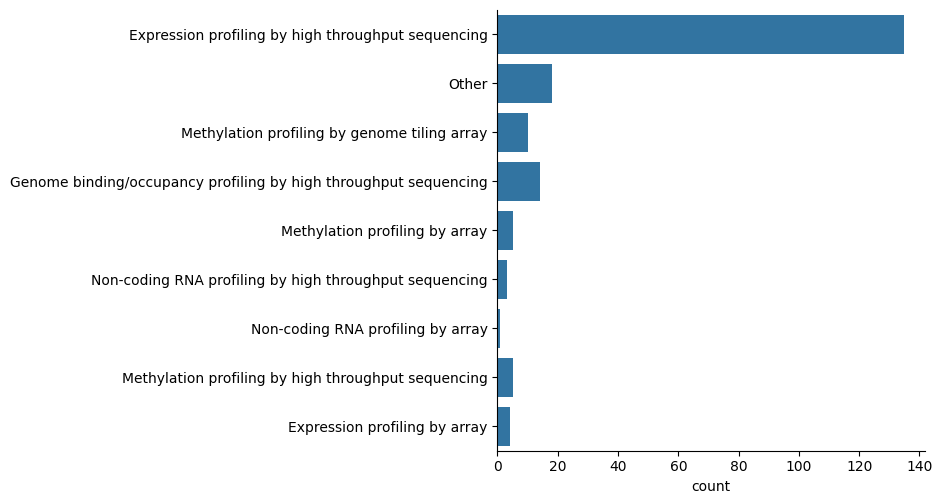

In [5]:
sns.catplot(experiment_types, kind="count")

Most experiments are done through expression profiling by high throughput sequencing.

## Organisms

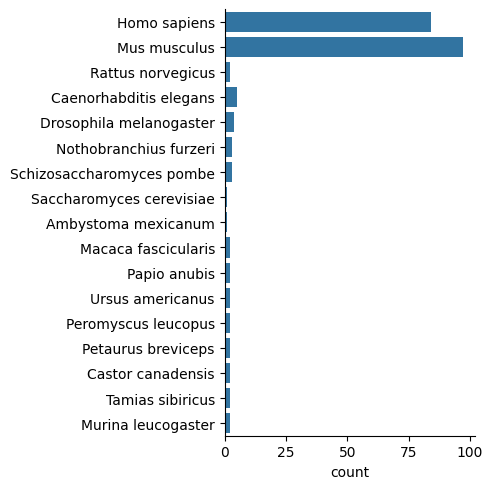

In [6]:
organisms = [organism for dataset in datasets for organism in dataset.organisms]
sns.catplot(organisms, kind="count")

Most datasets are collected from either mice or people.

In [7]:
## Title wordcolud

In [8]:
from typing import List
def plot_wordcloud(strings: List[str]):
    """
    Plots a wordcloud of a list of strings.
    """
    si = StringIO()
    for string in strings:
        si.write(string)
    text = si.getvalue()
    wordcloud = WordCloud().generate(text)
    wordcloud = WordCloud(background_color="white",max_words=len(text),max_font_size=40,).generate(text)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

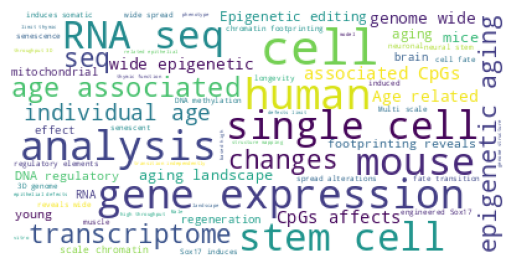

In [9]:
plot_wordcloud([dataset.title for dataset in datasets])

## Summary wordcolud

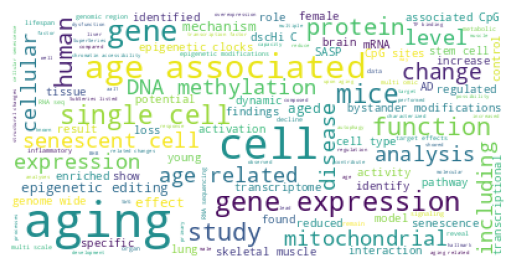

In [10]:
plot_wordcloud([dataset.summary for dataset in datasets])


## Overall design wordcolud

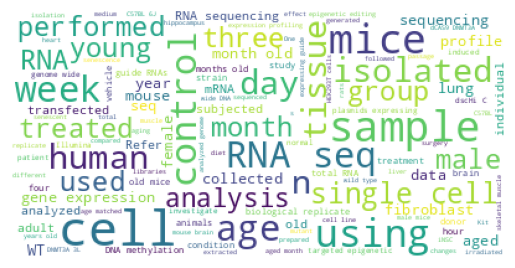

In [11]:
plot_wordcloud([dataset.overall_design for dataset in datasets])

## Platform ID counts

<Figure size 1000x2000 with 0 Axes>

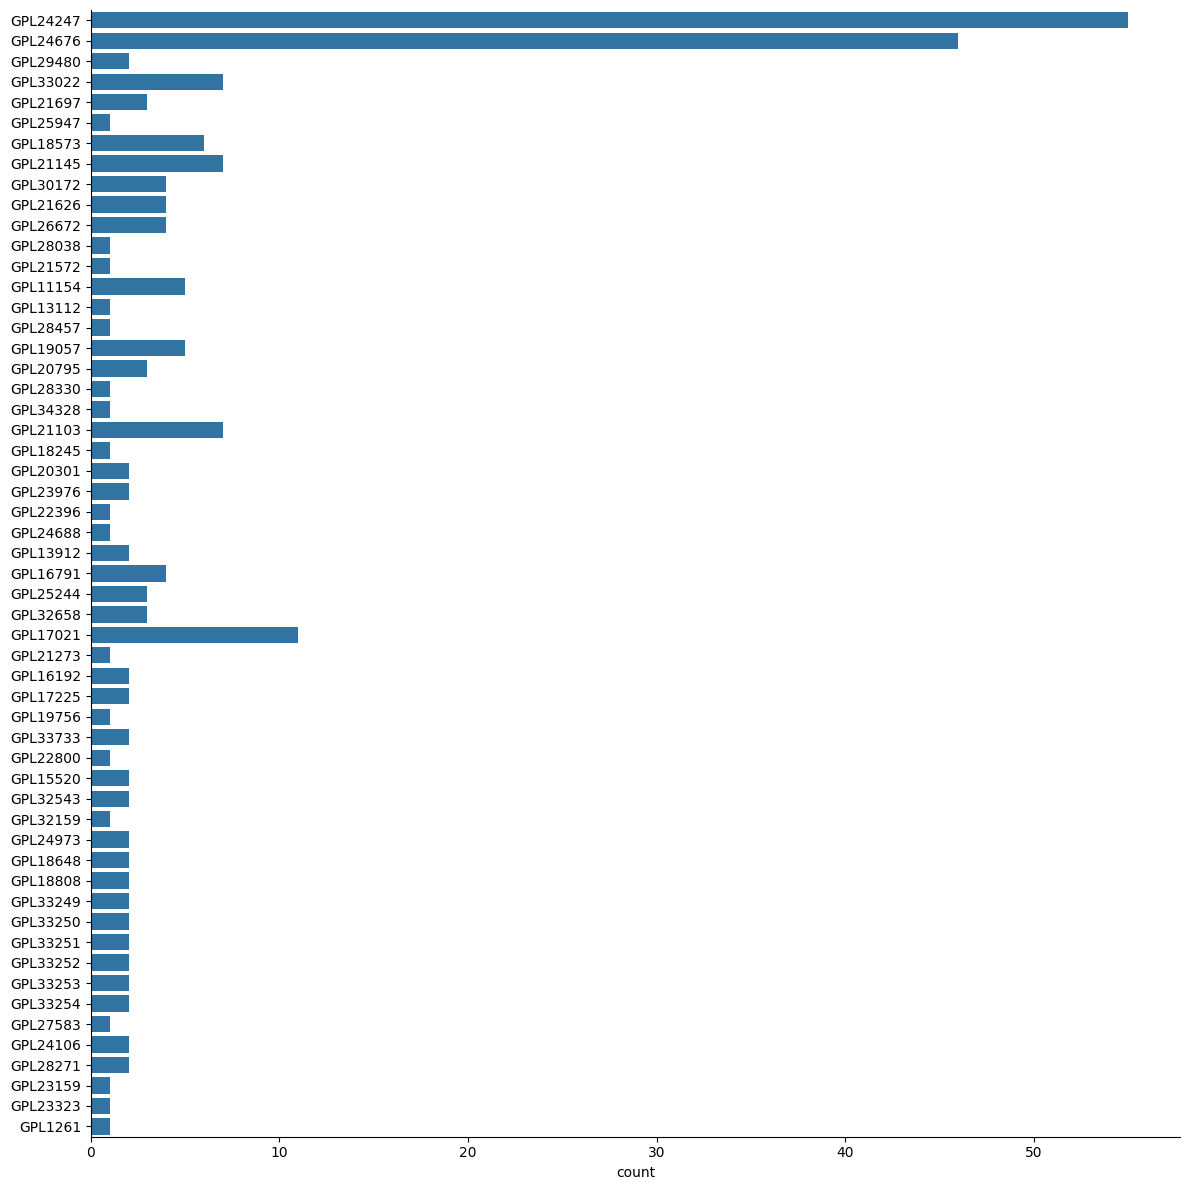

In [12]:
platform_ids = [platform_id for dataset in datasets for platform_id in dataset.platform_ids]
plt.figure(figsize=(10, 20))
sns.catplot(platform_ids, kind="count", height=12)
plt.show()

The top two platform IDs correspond to the Illumina Nova Seq 6000 sequencer. There is one platform record for when it is used and people and another one for mice. This is not surprising as Illumina sequencers are widely used in genomics research.

# Clustering

In [13]:
svd_dimensions = 15
topic_words = 10
best_result = None
best_score = 9999999
best_n_clusters = None

for n_clusters in range(5, 25):
    analyzer = DatasetAnalyzer(svd_dimensions, n_clusters)
    result = analyzer.analyze_datasets(datasets)
    if result.silhouette_score < best_score:
        best_score = result.silhouette_score
        best_result = result
        best_n_clusters = n_clusters

print(f"Best number of clusters {best_n_clusters}")

{"asctime": "2025-06-04 15:56:20,304", "levelname": "INFO", "message": "Explained variance of the SVD step: 32.2 %"}
{"asctime": "2025-06-04 15:56:20,318", "levelname": "INFO", "message": "Silhouette score: 0.22720326082559728"}
{"asctime": "2025-06-04 15:56:20,319", "levelname": "INFO", "message": "Clustering time: 0.01s"}
{"asctime": "2025-06-04 15:56:20,672", "levelname": "INFO", "message": "Explained variance of the SVD step: 32.2 %"}
{"asctime": "2025-06-04 15:56:20,686", "levelname": "INFO", "message": "Silhouette score: 0.20103014837863917"}
{"asctime": "2025-06-04 15:56:20,686", "levelname": "INFO", "message": "Clustering time: 0.01s"}
{"asctime": "2025-06-04 15:56:21,166", "levelname": "INFO", "message": "Explained variance of the SVD step: 32.2 %"}
{"asctime": "2025-06-04 15:56:21,186", "levelname": "INFO", "message": "Silhouette score: 0.23868926768799595"}
{"asctime": "2025-06-04 15:56:21,193", "levelname": "INFO", "message": "Clustering time: 0.03s"}
{"asctime": "2025-06-0

Similar datasets are located close to each other.
The color of a point represnts the topic of the dataset.

In [14]:
visualize_clusters_jupyter(best_result.df, best_result.cluster_topics)

Loading BokehJS ...

## Topics

In [15]:
topic_table = get_topic_table(best_result.cluster_topics, best_result.df)
topic_df = pd.DataFrame(topic_table, columns=["#", "Datasets", "Color", "Topics"])
topic_df = topic_df.set_index("#")
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# Apply styling to the 'color' column
topic_df = topic_df[["Color", "Datasets", "Topics"]].style.map(lambda x: f"background-color: {x};" if type(x) == str and x.startswith("#") else "")\
    .map(lambda x: f"color: {x};" if type(x) == str and x.startswith("#") else "")
topic_df

,Color,Datasets,Topics
#,,,
1,#1f77b4,54,"single, chromatin, reprogramming, changes, multi, structure, using, binding, dschi, associated"
2,#ff7f0e,45,"mitochondrial, lifespan, human, hair, related, years, non, analysis, metabolic, lung"
3,#2ca02c,45,"brain, mice, aged, old, young, mouse, analysis, musculus, month, senescence"
4,#d62728,24,"epigenetic, methylation, age, dna, editing, cpgs, modifications, wide, genome, associated"
5,#9467bd,14,"senescent, senescence, sasp, acss2, stress, er, promotes, complex, phenotype, hira"
6,#8c564b,13,"muscle, skeletal, dnmt3a, hypercapnia, mice, biopsies, autophagy, tg, sarcopenia, healthy"


# Sample metadata

In [16]:
# Download samples
samples = set() # We are using a set because some samples can occur twice. For example, a sample appears twice when it is in a subseries and superseries
async with aiohttp.ClientSession() as session:
    for series in datasets:
        series.samples = await download_samples(series, session)
        samples.update(series.samples)

accessions = [sample.accession for sample in samples]
assert len(set(accessions)) == len(samples)

## Number of samples

In [17]:
len(samples)

3931

## Most common sample types

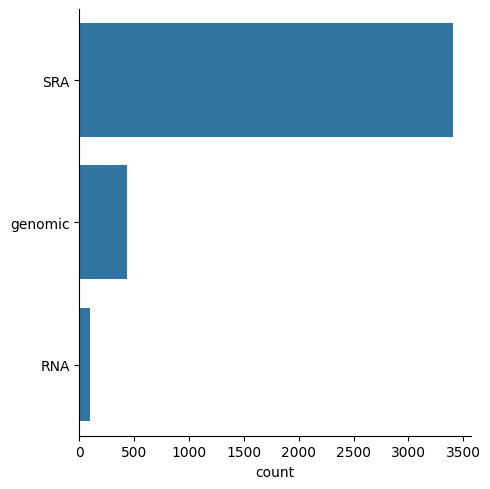

In [18]:
sample_types = [sample.sample_type for sample in samples]
sns.catplot(sample_types, kind="count")

## Most common characteristics keys

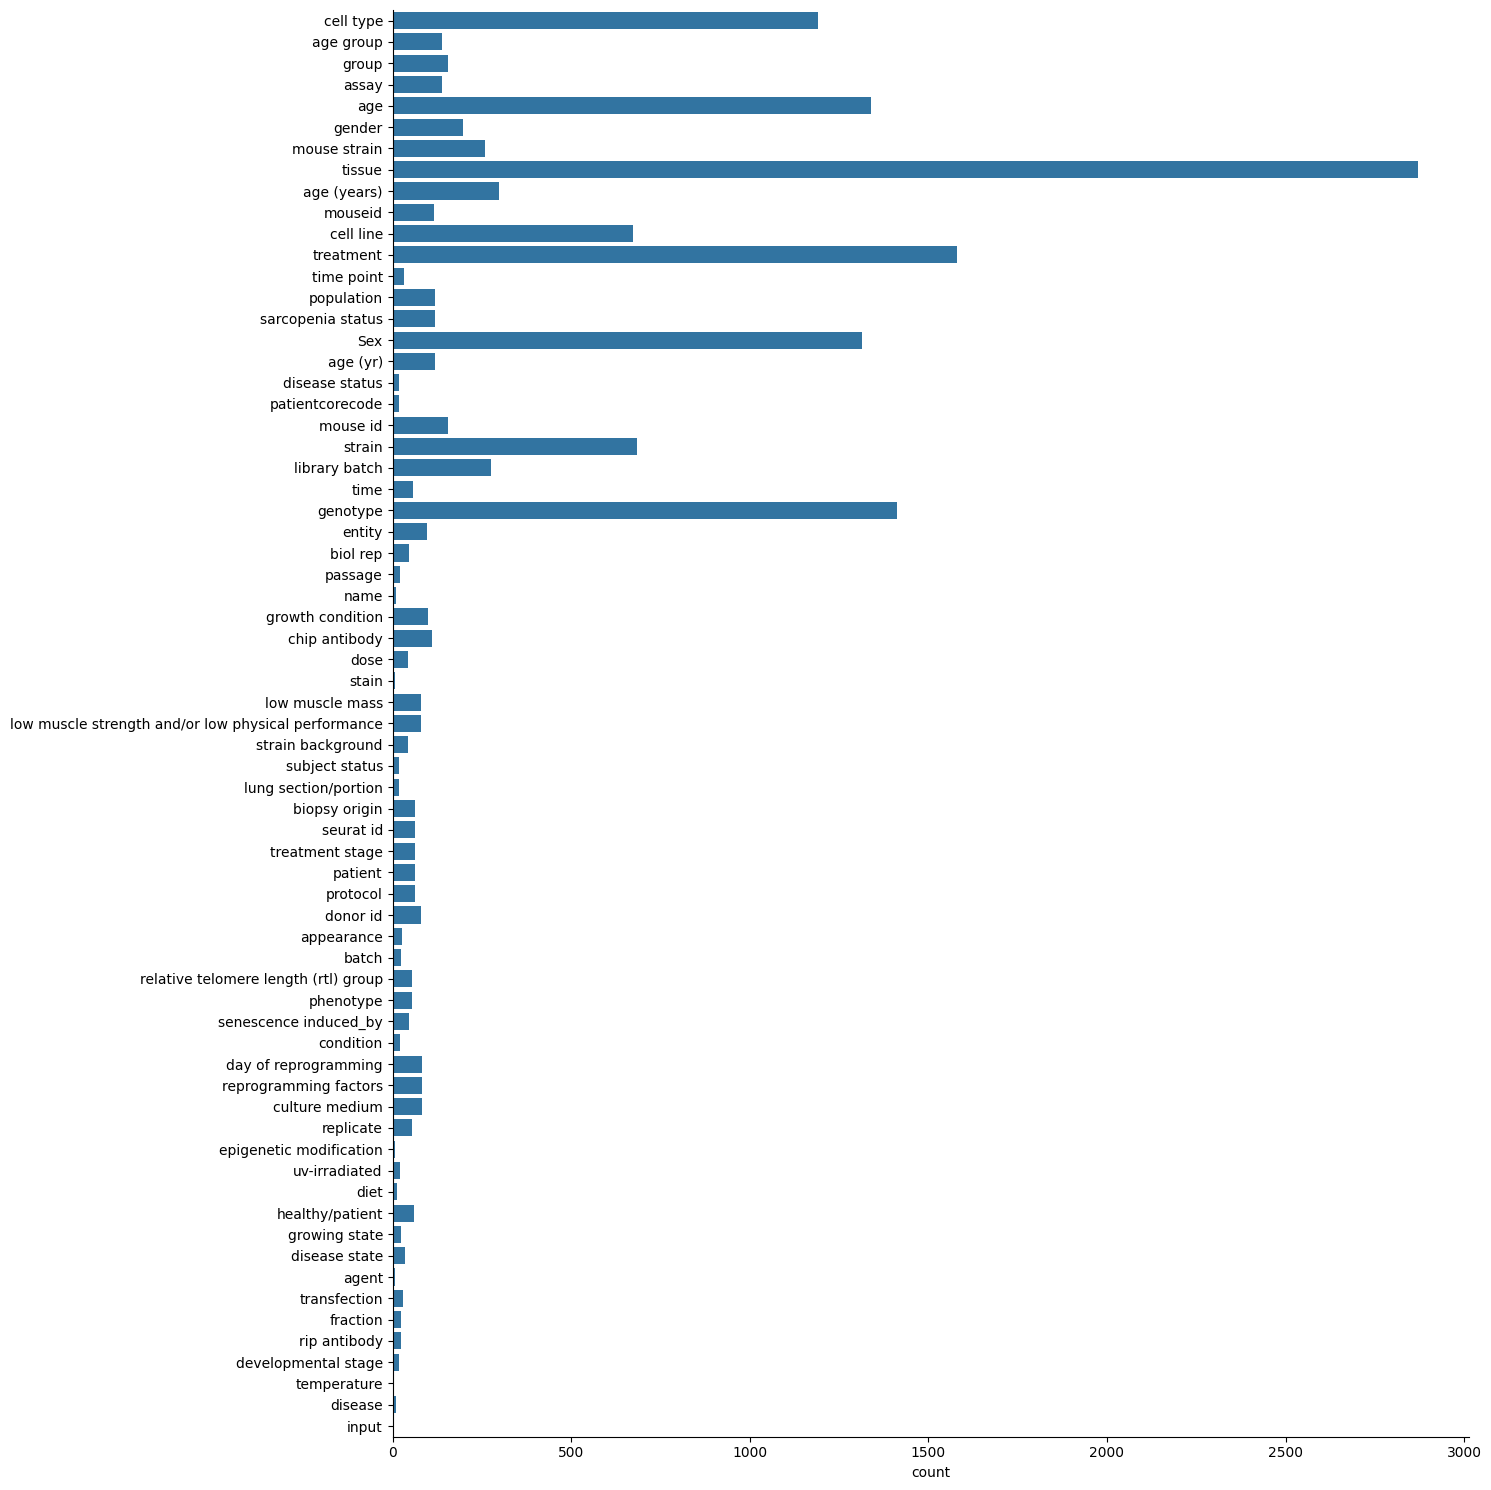

In [19]:
characteristics_keys = [key for sample in samples for key in sample.characteristics]
sns.catplot(characteristics_keys, kind="count", height=15)

In [20]:
pd.Series(characteristics_keys).value_counts().head(10)

tissue           2871
treatment        1580
genotype         1413
age              1339
Sex              1313
cell type        1192
strain            683
cell line         672
age (years)       297
library batch     275
Name: count, dtype: int64

## Number of samples that have data tables

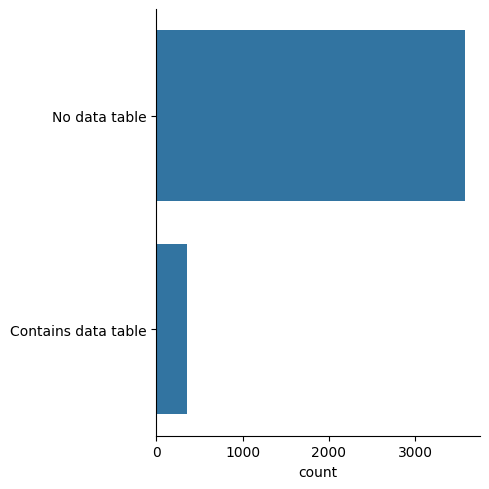

In [21]:
contains_data_table = ["Contains data table" if sample.metadata["data_row_count"][0] != "0" else "No data table" for sample in samples]
sns.catplot(contains_data_table, kind="count")

It seems that relatively few samples have data tables. Therefore, most data is raw sequencing data. 

## Most common tissues

Text(0.5, 1.0, 'Number of samples per tissue')

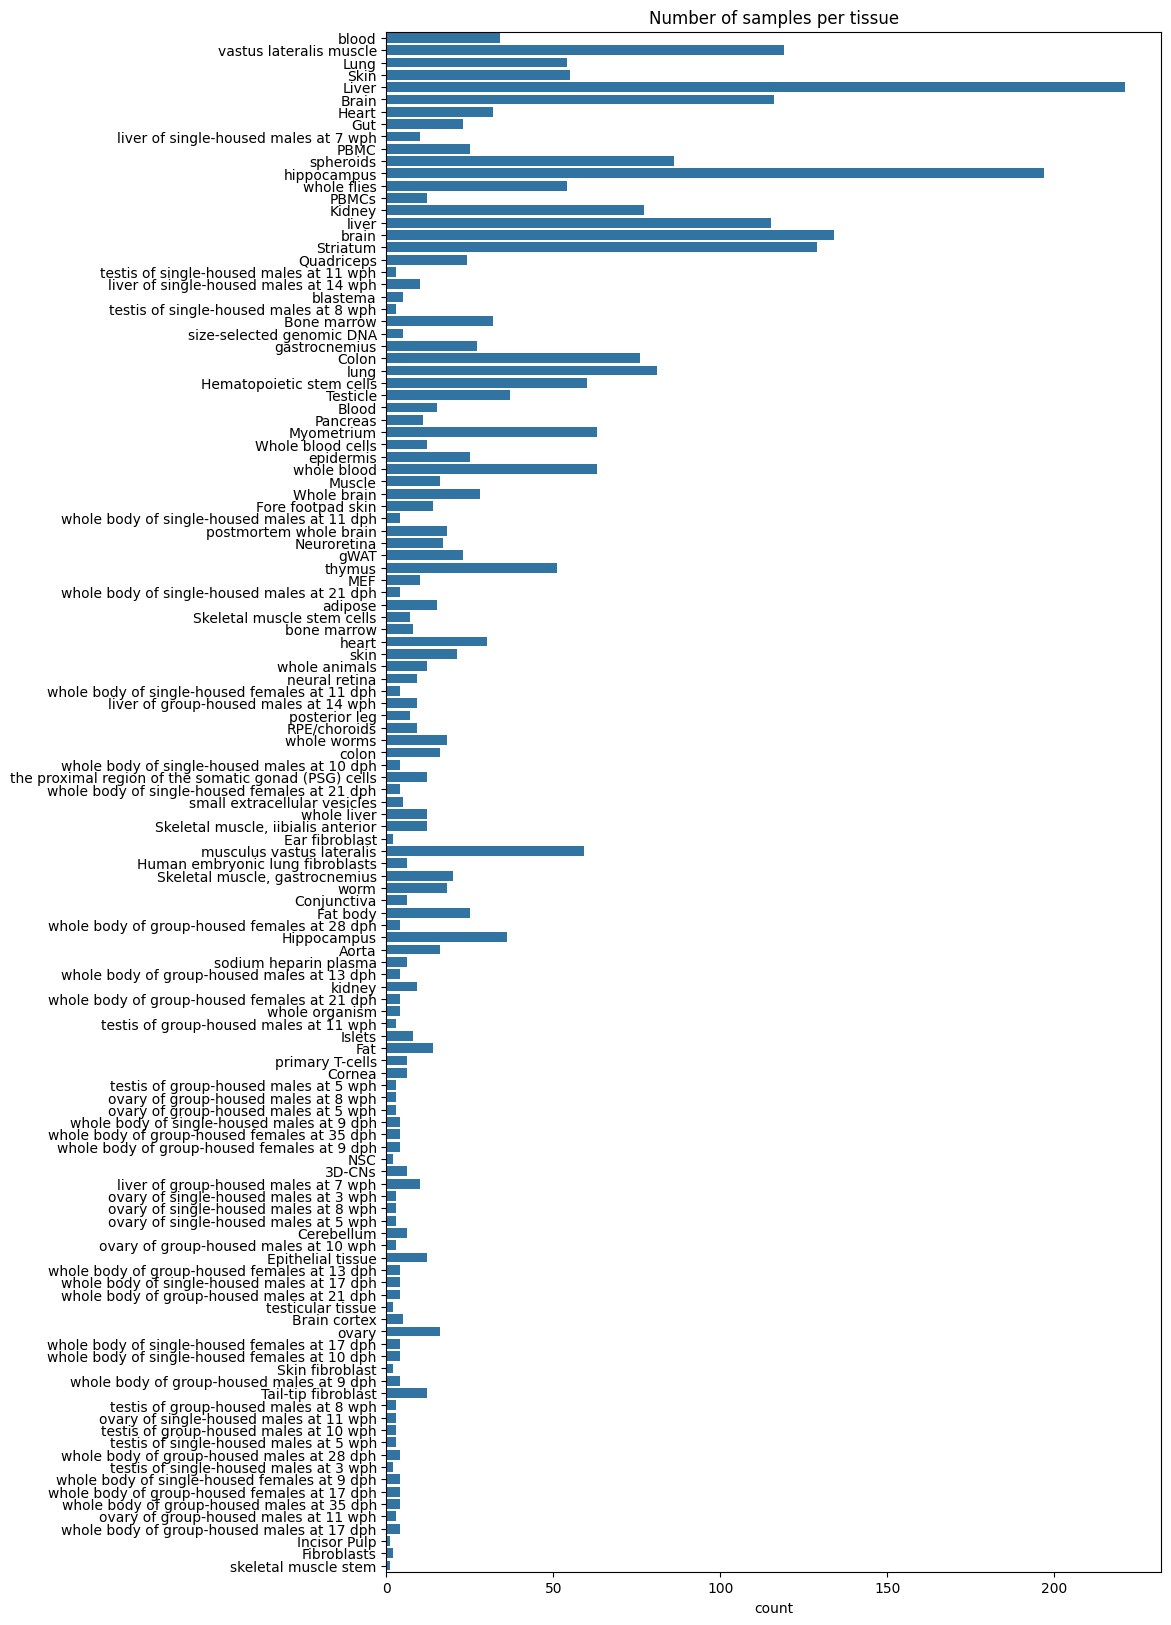

In [22]:
tissues = [sample.characteristics["tissue"] for sample in samples if "tissue" in sample.characteristics]
fig, ax = plt.subplots(figsize=(10, 20))
ax = sns.countplot(tissues, ax=ax)
ax.set_title("Number of samples per tissue")

There are different names for the same tissue depending on how specific the author wanted to be. Let's try grouping the synonyms together.

The following groupings were obtained using Gemma3-27B with the following prompt:

Here is a list of tissue names as extracted from Gene Expression Omnibus sample records. There are different names for the same kind of tissue in the list. Group the synonymous tissue names and give the group a meaningful name. If there are no synonyms for a tissue type create a new group for each such tissue.

Output a JSON where the keys are the group names and the values are the synonyms in that group.

List of tissue names: \<python list of tissue names\>

In [23]:
synonym_groups = \
{
  "Adipose Tissue": [
    "Fat",
    "gWAT",
    "adipose",
    "Fat body"
  ],
  "Blood": [
    "blood",
    "whole blood",
    "PBMCs",
    "PBMC",
    "Blood",
    "sodium heparin plasma",
    "Whole blood cells",
    "primary T-cells"
  ],
  "Bone": [
    "bone marrow",
    "Bone marrow"
  ],
  "Brain": [
    "NSC",
    "Striatum",
    "Brain",
    "Whole brain",
    "brain",
    "hippocampus",
    "Hippocampus",
    "Brain cortex",
    "Cerebellum",
    "postmortem whole brain",
    "neural retina",
    "Neuroretina",
    "RPE/choroids"
  ],
  "Colon": [
    "colon",
    "Colon",
    "Gut"
  ],
  "Connective Tissue": [
    "Tail-tip fibroblast",
    "Fibroblasts",
    "Skin fibroblast",
    "Ear fibroblast",
    "Human embryonic lung fibroblasts",
    "MEF"
  ],
  "Heart": [
    "Heart",
    "heart",
    "Aorta"
  ],
  "Kidney": [
    "Kidney",
    "kidney"
  ],
  "Liver": [
    "liver",
    "liver of group-housed males at 7 wph",
    "liver of group-housed males at 14 wph",
    "whole liver",
    "Liver",
    "liver of single-housed males at 14 wph",
    "liver of single-housed males at 7 wph"
  ],
  "Lung": [
    "Lung",
    "lung"
  ],
  "Muscle": [
    "Skeletal muscle stem cells",
    "gastrocnemius",
    "Skeletal muscle, iibialis anterior",
    "posterior leg",
    "Myometrium",
    "Muscle",
    "skeletal muscle stem",
    "musculus vastus lateralis",
    "Skeletal muscle, gastrocnemius",
    "vastus lateralis muscle",
    "Quadriceps"
  ],
  "Ovary": [
    "ovary of group-housed males at 8 wph",
    "ovary of single-housed males at 11 wph",
    "ovary",
    "ovary of single-housed males at 5 wph",
    "ovary of single-housed males at 8 wph",
    "ovary of single-housed males at 3 wph",
    "ovary of group-housed males at 11 wph",
    "ovary of group-housed males at 10 wph",
    "ovary of group-housed males at 5 wph"
  ],
  "Pancreas": [
    "Islets",
    "Pancreas"
  ],
  "Skin": [
    "Skin",
    "Fore footpad skin",
    "epidermis",
    "skin"
  ],
  "Testis": [
    "testis of group-housed males at 10 wph",
    "Testicle",
    "testis of single-housed males at 8 wph",
    "testis of single-housed males at 11 wph",
    "testis of single-housed males at 3 wph",
    "testis of group-housed males at 5 wph",
    "testicular tissue",
    "testis of group-housed males at 11 wph",
    "testis of group-housed males at 8 wph",
    "testis of single-housed males at 5 wph"
  ],
  "Whole Organism": [
    "whole flies",
    "whole body of group-housed males at 13 dph",
    "whole body of group-housed males at 17 dph",
    "whole body of group-housed males at 35 dph",
    "whole body of single-housed females at 17 dph",
    "whole body of group-housed females at 13 dph",
    "whole body of group-housed females at 9 dph",
    "whole body of group-housed males at 21 dph",
    "whole animals",
    "whole body of single-housed males at 11 dph",
    "whole body of single-housed males at 21 dph",
    "whole body of group-housed females at 35 dph",
    "whole body of group-housed females at 17 dph",
    "whole body of single-housed females at 10 dph",
    "whole body of group-housed males at 28 dph",
    "worm",
    "whole organism",
    "whole body of single-housed females at 11 dph",
    "whole body of single-housed females at 21 dph",
    "whole body of single-housed males at 17 dph",
    "whole body of single-housed males at 10 dph",
    "whole body of single-housed males at 9 dph",
    "whole body of single-housed females at 9 dph",
    "whole body of group-housed females at 21 dph",
    "whole body of group-housed females at 28 dph",
    "whole worms",
    "whole body of group-housed males at 9 dph"
  ],
  "Blastema": [
    "blastema"
  ],
  "Small Extracellular Vesicles": [
    "small extracellular vesicles"
  ],
  "Incisor Pulp": [
    "Incisor Pulp"
  ],
  "Hematopoietic Stem Cells": [
    "Hematopoietic stem cells"
  ],
  "Epithelial Tissue": [
    "Epithelial tissue"
  ],
  "Size-Selected Genomic DNA": [
    "size-selected genomic DNA"
  ],
  "Conjunctiva": [
    "Conjunctiva"
  ],
  "Cornea": [
    "Cornea"
  ],
  "Proximal Somatic Gonad Cells": [
    "the proximal region of the somatic gonad (PSG) cells"
  ],
  "3D-CNs": [
    "3D-CNs"
  ],
  "Spheroids": [
    "spheroids"
  ],
  "Thymus": [
    "thymus"
  ]
}
tissue_to_group_mapping = {tissue: group for group, tissue_list in synonym_groups.items() for tissue in tissue_list}

In [24]:
tissues = [tissue_to_group_mapping[tissue] for tissue in tissues]

Text(0.5, 1.0, 'Number of samples per tissue (synonyms grouped)')

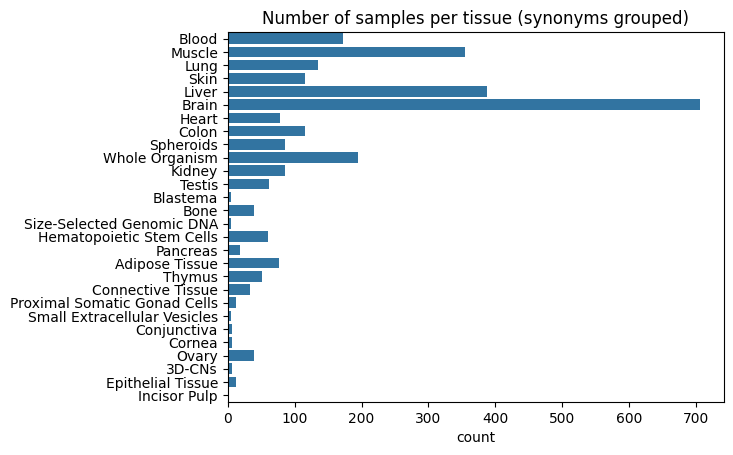

In [25]:
ax = sns.countplot(tissues)
ax.set_title("Number of samples per tissue (synonyms grouped)")

## Most common cell types

Text(0.5, 1.0, 'Number of samples per cell type')

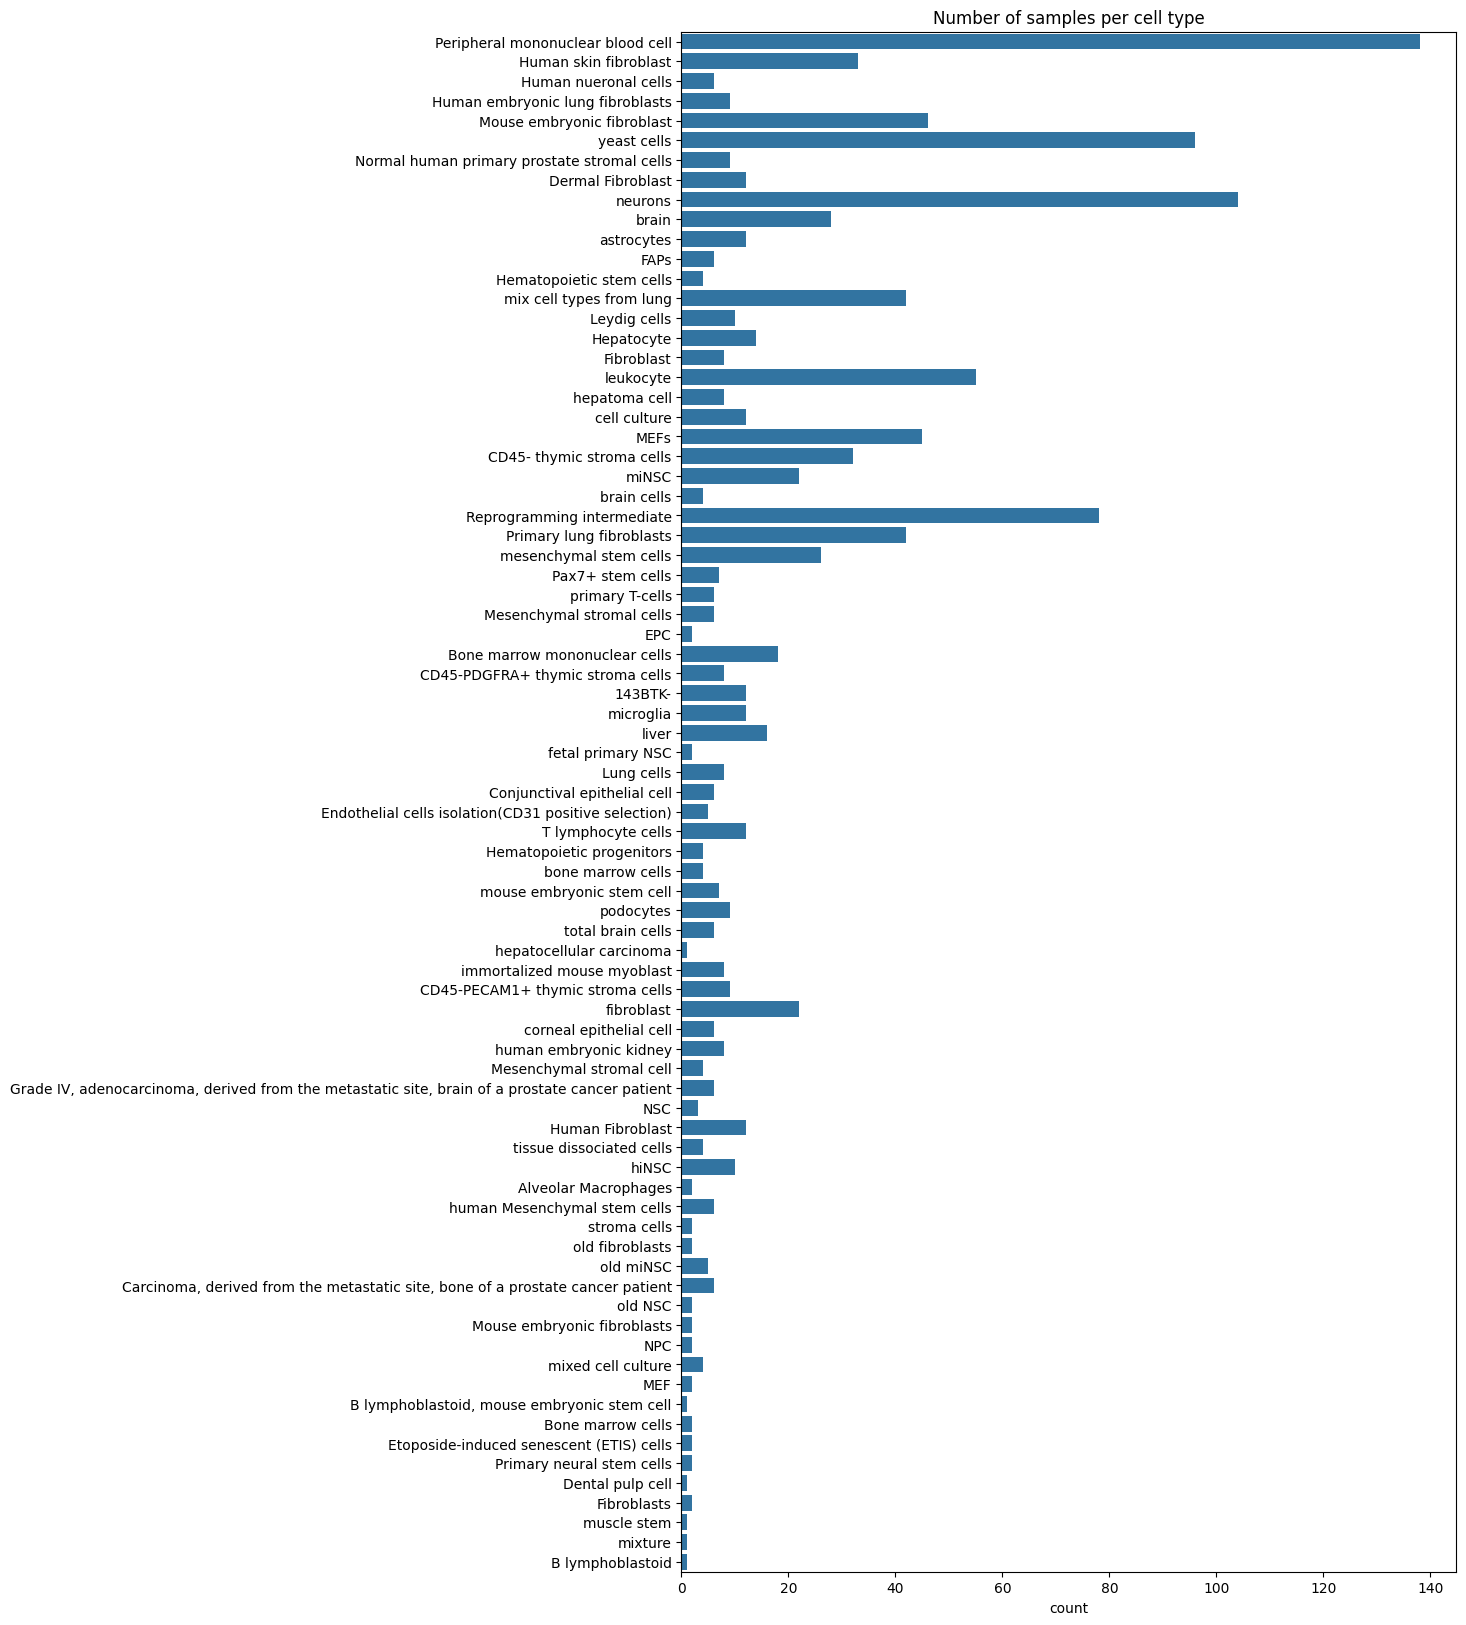

In [26]:
tissues = [sample.characteristics["cell type"] for sample in samples if "cell type" in sample.characteristics]
fig, ax = plt.subplots(figsize=(10, 20))
ax = sns.countplot(tissues, ax=ax)
ax.set_title("Number of samples per cell type")

There are synonyms here as well.

As a side note, let's see if most samples contain either the tissue type or cell type as both are indicative of the tissue being studied. 

In [27]:
contains_tissue_or_cell_type = [sample for sample in samples if "tissue" in sample.characteristics or "cell type" in sample.characteristics]
n_samples = len(samples)
n_contains = len(contains_tissue_or_cell_type)
print(f"{n_contains}/{n_samples} ({n_contains / n_samples * 100}%) contain tissue information")

3539/3931 (90.02798270160265%) contain tissue information


## Values of other characteristics fields

Time

In [30]:
time_values = [sample.characteristics["time"] for sample in samples if "time" in sample.characteristics]
time_values += [sample.characteristics["time point"] for sample in samples if "time point" in sample.characteristics]
for time in set(time_values):
    print(time)


d0 (1st Day of adulthood)
isolation after 11 days after transfection
isolation after 21 days of culture
d0
7 hours
72 h
isolation after 14 days of culture
isolation after 11 days of culture
isolation after 7 days of culture


Age

In [32]:
age_keys = set([key for key in characteristics_keys if "age" in key.split(" ")])
age_values = []
for age_key in age_keys:
    age_values += [sample.characteristics[age_key] for sample in samples if age_key in sample.characteristics]
print("Keys:", age_keys)
for age_value in set(age_values):
    print(age_value)

Keys: {'age group', 'age (years)', 'age', 'age (yr)'}
14 weeks
72.4
11.1 weeks
20-22 months old
0-year-old
27 months
88
12.4 weeks
35
73.5
Day 1 of adulthood
11.7 weeks
29 years
31 years
P28
21-22months old
73
31
75.1
15 Months
54 years
43
34
48 years
55
40
38
68.4
73.2
74.5
79
28
Aged
68.8
33
67 years
63
8 days
49
24 months
2.166666667
4 months
32 years
56 years
110+
67 years old
61 years
3 months
12.6 weeks
2
48
55 years
41
Young
37
75.8
27
1.75
81
23
45
29
59 years
adult
2 mounth
75
86
80
72.3
73.9
36
60 years
25 years
28 years
57 years
71.5
57
49 years
9 Months
67
73.7
66
24 Months
young fertile adults (17-22 years old)
54
60
24 months old
Young Adult
24-month
0.333333333
P38
44
62
24 mo
11 months
20-month old
58
76.7
76.8
100
2.5-year-old
26
76.2
30 years
males, 10-days-old
51
85
11.9 weeks
62 years
70.4
83
42 years
99
63 years
6 weeks old
64 years
65
65 years
58 years
40 years
54 years old
76.6
70
24mo
74 years old
2 month
Old
12 months
42
25
70.3
71.8
74.2
39
12 mounth
02-month 

## Parsing age fields

Age is usually represented here as a number or range followed by a unit, or just a number.
However there are excpetions to this rule, for example ">60 years old", and they have to be handled differently.
There are also non-numerical descriptions such as Young, Middle and Old which cannot be converted into numbers.

In [35]:
import re
INF_AGE = 999
MIN_AGE = 0


def normalize_to_years(value, unit):
    """Converts age to years based on the unit."""
    unit = unit.lower()
    if unit in ['year', 'years', 'yr', 'yrs', 'y']:
        return float(value)
    elif unit in ['month', 'months', 'mo', 'mos']:
        return float(value) / 12.0
    elif unit in ['week', 'weeks', 'wks', 'wk', 'w']:
        return float(value) / 52.0
    elif unit in ['day', 'days', 'd']:
        return float(value) / 365.0
    return None  # Should not happen if regex is correct


def extract_age(age_str: str):
    """
    Extratcts age in years or a range from a piece of text 
    stating the age or age group.
    If the age cannot be determined, the function returns null.

    :param age_str: Text from which to extract the age
    :returns: A single number containing the age or a pair if a range was detected.
    """
    age_str = str(age_str).lower().strip()  # Normalize text

    if is_number(age_str):
        return float(age_str)  # assume age is in years

    is_age_range, age_range = try_extract_age_range(age_str)
    if is_age_range:
        return age_range

    is_age_plus_unit, age = try_extract_age_plus_unit(age_str)
    if is_age_plus_unit:
        return age

    # Handle 110+
    is_age_plus, age_range = try_extract_age_plus(age_str)
    if is_age_plus:
        return age_range

    # Handle >60
    is_greater_than_age, age_range = try_extract_greater_than_age(age_str)
    if is_greater_than_age:
        return age_range
    
    # Handle <60
    is_less_than_age, age_range = try_extract_less_than_age(age_str)
    if is_less_than_age:
        return age_range
    
    return None


def try_extract_age_range(age_str: str):
    match = re.search(
        r'(\d+\.?\d*)\s*-\s*(\d+\.?\d*)\s*(year|yr|month|mo|week|wk|day|d)?s?\s*(old)?', age_str)
    if not match:
        return False, None
    val1 = float(match.group(1))
    val2 = float(match.group(2))
    unit = match.group(3)
    if unit:
        return True, (normalize_to_years(val1, unit), normalize_to_years(val2, unit))
    else:
        return True, (val1, val2)  # Assume years


def try_extract_age_plus_unit(age_str: str):
    match = re.search(
        r'(\d+\.?\d*)\s*-?\s*(year|yr|month|mo|week|wk|day|d)s?\s*-?\s*(old)?', age_str)
    if not match:
        return False, None
    if match:
        value = float(match.group(1))
        unit = match.group(2)
        return True, normalize_to_years(value, unit)


def try_extract_age_plus(age_str: str):
    """
    Tries to extract ages like 110+ out of the text.
    """
    match = re.search(r'(\d+)\+', age_str)
    if not match:
        return False, None
    if match:
        return True, (MIN_AGE, match.group(1))


def try_extract_greater_than_age(age_str: str):
    """
    Tries to extract ages like >20 out of the text.
    """
    match = re.search(r'\>(\d+)', age_str)
    if not match:
        return False, None
    if match:
        return True, (match.group(1), INF_AGE)


def try_extract_less_than_age(age_str: str):
    """
    Tries to extract ages like <20 out of the text.
    """
    match = re.search(r'\<(\d+)', age_str)
    if not match:
        return False, None
    if match:
        return True, (match.group(1), INF_AGE)


def is_number(text):
    try:
        float(text)
        return True
    except:
        return False

In [34]:
for age in age_values:
    print(age, extract_age(age))

Young None
Middle None
Young None
Old None
Middle None
Middle None
Young None
Old None
Young None
Old None
Young None
Middle None
Young None
Old None
Young None
Middle None
Middle None
Middle None
Young None
Middle None
Old None
Old None
Old None
Old None
Middle None
Young None
Young None
Young None
Young None
Middle None
Young None
Old None
Old None
Young None
Old None
Young None
Young None
Old None
Young None
Young None
Old None
Old None
Old None
Middle None
Old None
Old None
Young None
Young None
Old None
Middle None
Old None
Young None
Middle None
Old None
Young None
Middle None
Old None
Old None
Old None
Old None
Old None
Young None
Middle None
Old None
Middle None
Middle None
Middle None
Middle None
Old None
Middle None
Young None
Young None
Old None
Middle None
Middle None
Young None
Middle None
Young None
Middle None
Middle None
Young None
Middle None
Middle None
Middle None
Old None
Young None
Middle None
Old None
Young None
Old None
Old None
Old None
Young None
Young None
Mid